<a href="https://colab.research.google.com/github/dgavieira/regularization/blob/main/2_overfitting_avoiding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importação das Bibliotecas e Carregamento dos Dados

In [21]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2

# Carregar a base de dados do arquivo CSV
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
column_names = ['ID', 'Diagnosis'] + [f'Feature_{i}' for i in range(1, 31)]
data = pd.read_csv(url, header=None, names=column_names)

# Separar as características e o alvo
X = data.drop(['ID', 'Diagnosis'], axis=1)
y = data['Diagnosis']

# Converter a coluna 'Diagnosis' para binário: M (maligno) = 1, B (benigno) = 0
y = y.map({'M': 1, 'B': 0})

# Dividir o conjunto de dados em treinamento (80%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


## 2. Função para definir os callbacks

In [22]:
def create_callbacks(filepath='/tmp/ckpt/checkpoint.model.keras'):
    # Callback para salvar o modelo com melhor acurácia no conjunto de validação
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=filepath,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    # Callback para parada antecipada
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    return [model_checkpoint_callback, early_stopping_callback]


## 3. Definir o Modelo Sem Regularização

In [23]:
# Definir o modelo sem regularização
def create_model_no_regularization():
    model = Sequential([
        Dense(16, input_shape=(X_train.shape[1],), activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


## 4. Definir o modelo sem regularização com parada antecipada

In [24]:
# Definir o modelo sem regularização com parada antecipada
def create_model_no_reg_early_stop():
    model = create_model_no_regularization()
    callbacks = create_callbacks()
    return model, callbacks


## 5. Definir o Modelo com Regularização L2

In [25]:
# Definir o modelo com regularização L2
def create_model_l2():
    model = Sequential([
        Dense(16, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l2(0.01)),
        Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


## 6. Definir o modelo com regularização L1

In [26]:
# Definir o modelo com regularização L1
def create_model_l1():
    model = Sequential([
        Dense(16, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l1(0.01)),
        Dense(8, activation='relu', kernel_regularizer=l1(0.01)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


## 7. Definir o modelo com Dropout

In [27]:
# Definir o modelo com Dropout de 30% na segunda camada
def create_model_dropout():
    model = Sequential([
        Dense(16, input_shape=(X_train.shape[1],), activation='relu'),
        Dropout(0.3),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


## 8. Definir o modelo com Dropout e Regularizção L2

In [28]:
# Definir o modelo com Dropout e Regularização L2
def create_model_dropout_l2():
    model = Sequential([
        Dense(16, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


## 9. Treinar e avaliar os modelos

In [29]:
# Função para treinar e avaliar o modelo
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs, callbacks=None):
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    # Avaliar o desempenho no conjunto de teste
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Loss no teste: {test_loss:.4f}, Acurácia no teste: {test_accuracy:.4f}")

    return history


In [30]:
# Treinar o modelo sem regularização
model_no_reg = create_model_no_regularization()
history_no_reg = train_and_evaluate_model(model_no_reg, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.6048 - loss: 0.6470 - val_accuracy: 0.7018 - val_loss: 0.4668
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7318 - loss: 0.4817 - val_accuracy: 0.7632 - val_loss: 0.3821
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7653 - loss: 0.4431 - val_accuracy: 0.8246 - val_loss: 0.3333
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8158 - loss: 0.3935 - val_accuracy: 0.8684 - val_loss: 0.2980
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8752 - loss: 0.3473 - val_accuracy: 0.9123 - val_loss: 0.2658
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8908 - loss: 0.3011 - val_accuracy: 0.9474 - val_loss: 0.2355
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9235 - loss: 0.2665 - val_accuracy: 0.9561 - val_loss: 0.2099
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9263 - loss: 0.2620 - val_accuracy: 0.9825 - val_loss: 

In [31]:
# Treinar o modelo sem regularização com parada antecipada
model_no_reg_early_stop, callbacks_no_reg_early_stop = create_model_no_reg_early_stop()
history_no_reg_early_stop = train_and_evaluate_model(model_no_reg_early_stop, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100, callbacks=callbacks_no_reg_early_stop)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.4036 - loss: 0.7757 - val_accuracy: 0.5702 - val_loss: 0.6585
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6107 - loss: 0.6698 - val_accuracy: 0.7807 - val_loss: 0.5471
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8110 - loss: 0.5419 - val_accuracy: 0.8509 - val_loss: 0.4630
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8777 - loss: 0.4843 - val_accuracy: 0.8947 - val_loss: 0.3993
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9141 - loss: 0.4239 - val_accuracy: 0.9211 - val_loss: 0.3457
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9205 - loss: 0.3763 - val_accuracy: 0.9298 - val_loss: 0.2984
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9381 - loss: 0.3231 - val_accuracy: 0.9386 - val_loss: 0.2570
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9347 - loss: 0.3051 - val_accuracy: 0.94

In [32]:
# Treinar o modelo com regularização L2
model_l2 = create_model_l2()
history_l2 = train_and_evaluate_model(model_l2, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.6261 - loss: 0.9352 - val_accuracy: 0.7982 - val_loss: 0.8649
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8301 - loss: 0.8300 - val_accuracy: 0.9123 - val_loss: 0.7700
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9292 - loss: 0.7568 - val_accuracy: 0.9298 - val_loss: 0.6944
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9119 - loss: 0.6881 - val_accuracy: 0.9386 - val_loss: 0.6313
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9561 - loss: 0.6152 - val_accuracy: 0.9561 - val_loss: 0.5740
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9528 - loss: 0.5707 - val_accuracy: 0.9561 - val_loss: 0.5253
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9626 - loss: 0.5097 - val_accuracy: 0.9561 - val_loss: 0.4836
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9644 - loss: 0.4818 - val_accuracy: 0.964

In [33]:
# Treinar o modelo com regularização L1
model_l1 = create_model_l1()
history_l1 = train_and_evaluate_model(model_l1, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.8796 - loss: 1.6568 - val_accuracy: 0.9386 - val_loss: 1.5382
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9229 - loss: 1.5684 - val_accuracy: 0.9386 - val_loss: 1.4540
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9515 - loss: 1.4917 - val_accuracy: 0.9561 - val_loss: 1.3777
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9583 - loss: 1.4123 - val_accuracy: 0.9649 - val_loss: 1.3103
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9601 - loss: 1.3305 - val_accuracy: 0.9825 - val_loss: 1.2487
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9429 - loss: 1.2879 - val_accuracy: 0.9825 - val_loss: 1.1924
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9577 - loss: 1.2120 - val_accuracy: 0.9825 - val_loss: 1.1400
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9469 - loss: 1.1758 - val_accuracy: 0.9825 -

In [34]:
# Treinar o modelo com Dropout
model_dropout = create_model_dropout()
history_dropout = train_and_evaluate_model(model_dropout, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.3938 - loss: 0.7942 - val_accuracy: 0.4474 - val_loss: 0.6988
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5485 - loss: 0.6576 - val_accuracy: 0.7018 - val_loss: 0.5941
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7070 - loss: 0.5797 - val_accuracy: 0.8158 - val_loss: 0.5032
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8017 - loss: 0.5050 - val_accuracy: 0.8860 - val_loss: 0.4210
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8834 - loss: 0.4320 - val_accuracy: 0.9123 - val_loss: 0.3431
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9022 - loss: 0.4001 - val_accuracy: 0.9474 - val_loss: 0.2811
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8942 - loss: 0.3529 - val_accuracy: 0.9474 - val_loss: 0.2343
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9082 - loss: 0.3193 - val_accuracy: 0.9474

In [35]:
# Treinar o modelo com Dropout e Regularização L2
model_dropout_l2 = create_model_dropout_l2()
history_dropout_l2 = train_and_evaluate_model(model_dropout_l2, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.5350 - loss: 1.1535 - val_accuracy: 0.6491 - val_loss: 0.9508
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6786 - loss: 1.0090 - val_accuracy: 0.7281 - val_loss: 0.8211
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7250 - loss: 0.9161 - val_accuracy: 0.8158 - val_loss: 0.7275
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7324 - loss: 0.8681 - val_accuracy: 0.8860 - val_loss: 0.6595
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8592 - loss: 0.7216 - val_accuracy: 0.9123 - val_loss: 0.6098
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8462 - loss: 0.7331 - val_accuracy: 0.9474 - val_loss: 0.5695
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8906 - loss: 0.6193 - val_accuracy: 0.9561 - val_loss: 0.5351
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8879 - loss: 0.6110 - val_accuracy: 0.9561 -

## Escolha do melhor modelo

In [36]:
# Carregar o melhor modelo salvo durante o treinamento (se aplicável)
best_model = keras.models.load_model('/tmp/ckpt/checkpoint.model.keras')

# Avaliar o desempenho do melhor modelo no conjunto de teste
best_test_loss, best_test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Melhor Loss no teste: {best_test_loss:.4f}, Melhor Acurácia no teste: {best_test_accuracy:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9707 - loss: 0.1106
Melhor Loss no teste: 0.1017, Melhor Acurácia no teste: 0.9737


In [37]:
import matplotlib.pyplot as plt

def plot_history(history, title="Model Performance"):
    # Obter os valores finais de acurácia e perda
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    plt.figure(figsize=(12, 5))

    # Plotar acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f'Treinamento (Acurácia: {final_train_accuracy:.4f})')
    plt.plot(history.history['val_accuracy'], label=f'Validação (Acurácia: {final_val_accuracy:.4f})')
    plt.title('Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Plotar perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f'Treinamento (Perda: {final_train_loss:.4f})')
    plt.plot(history.history['val_loss'], label=f'Validação (Perda: {final_val_loss:.4f})')
    plt.title('Perda')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.suptitle(title)
    plt.show()


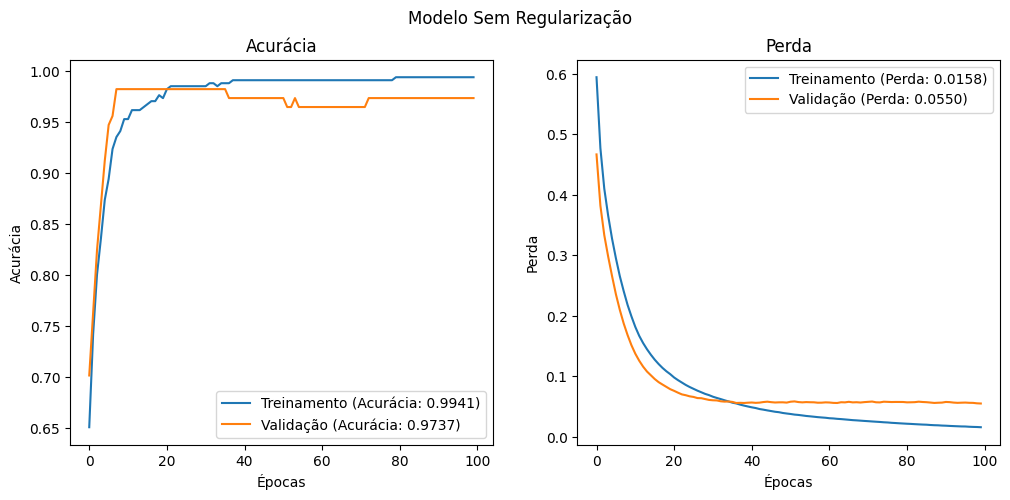

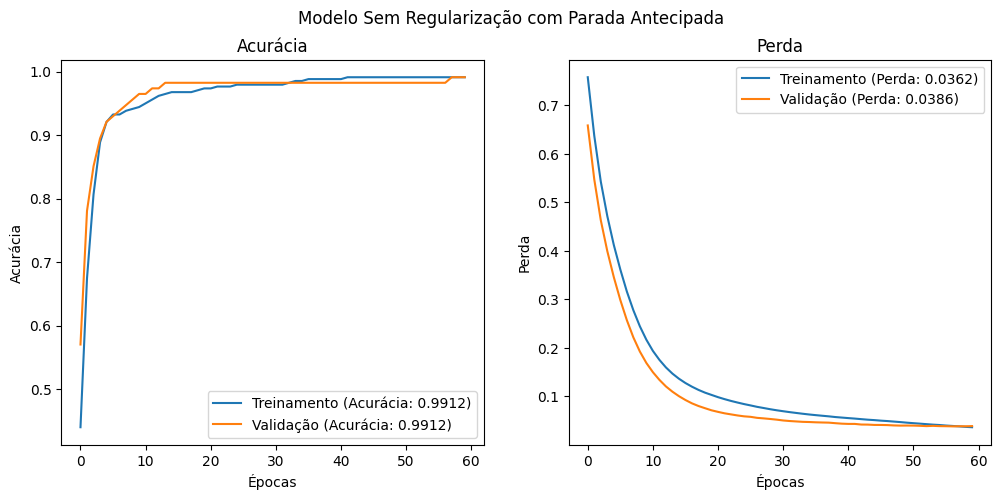

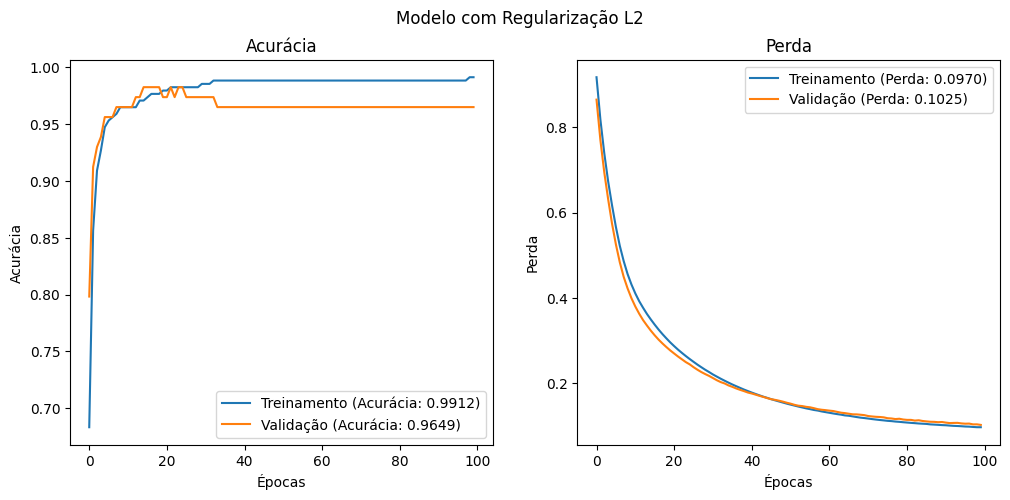

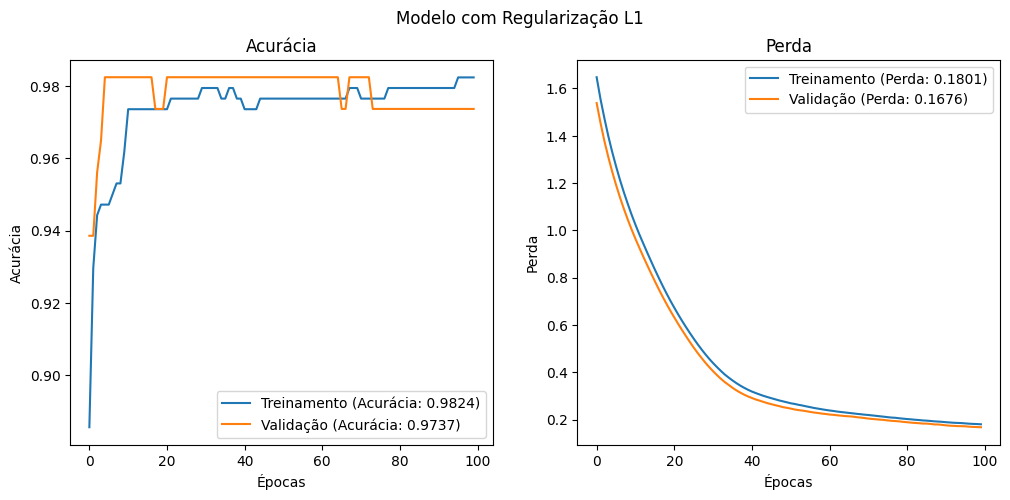

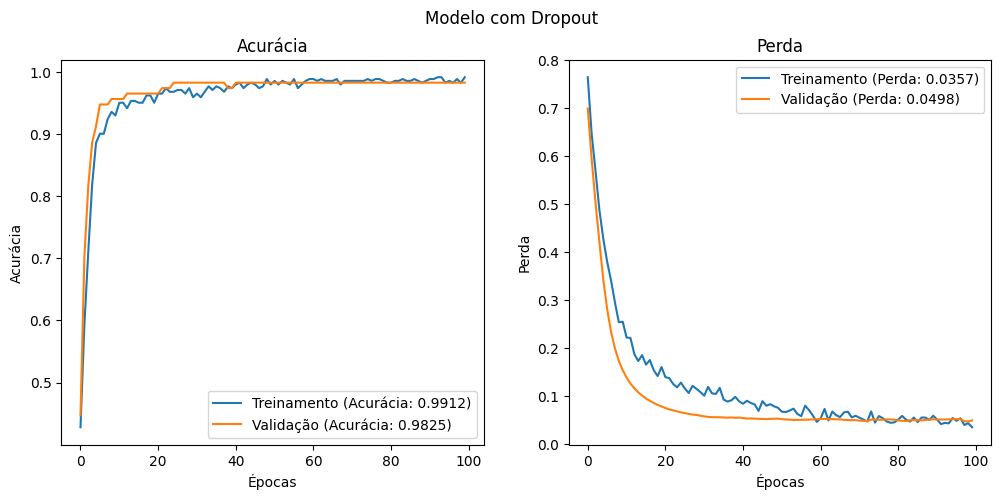

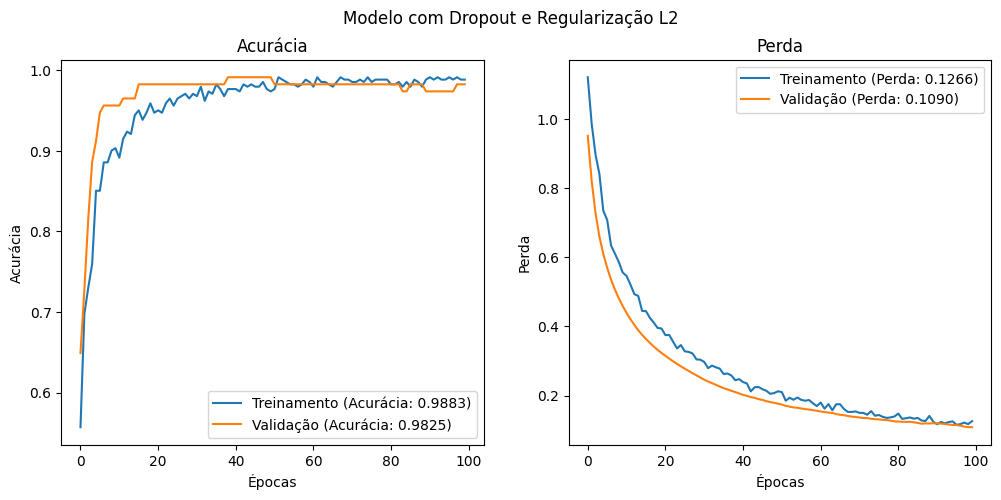

In [38]:
# Suponha que você tenha o histórico de treinamento do modelo sem regularização
plot_history(history_no_reg, title="Modelo Sem Regularização")

# Repita para outros históricos conforme necessário
plot_history(history_no_reg_early_stop, title="Modelo Sem Regularização com Parada Antecipada")
plot_history(history_l2, title="Modelo com Regularização L2")
plot_history(history_l1, title="Modelo com Regularização L1")
plot_history(history_dropout, title="Modelo com Dropout")
plot_history(history_dropout_l2, title="Modelo com Dropout e Regularização L2")


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8525 - loss: 0.5391 - val_accuracy: 0.9035 - val_loss: 0.4368
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8658 - loss: 0.4518 - val_accuracy: 0.9298 - val_loss: 0.3599
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8848 - loss: 0.3880 - val_accuracy: 0.9386 - val_loss: 0.3002
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9131 - loss: 0.3269 - val_accuracy: 0.9474 - val_loss: 0.2522
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8995 - loss: 0.3013 - val_accuracy: 0.9474 - val_loss: 0.2165
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9295 - loss: 0.2467 - val_accuracy: 0.9561 - val_loss: 0.1887
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9209 - loss: 0.2217 - val_accuracy: 0.9561 - val_loss: 0.1660
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9394 - loss: 0.1934 - val_accuracy: 0.9649 - val_loss: 0.

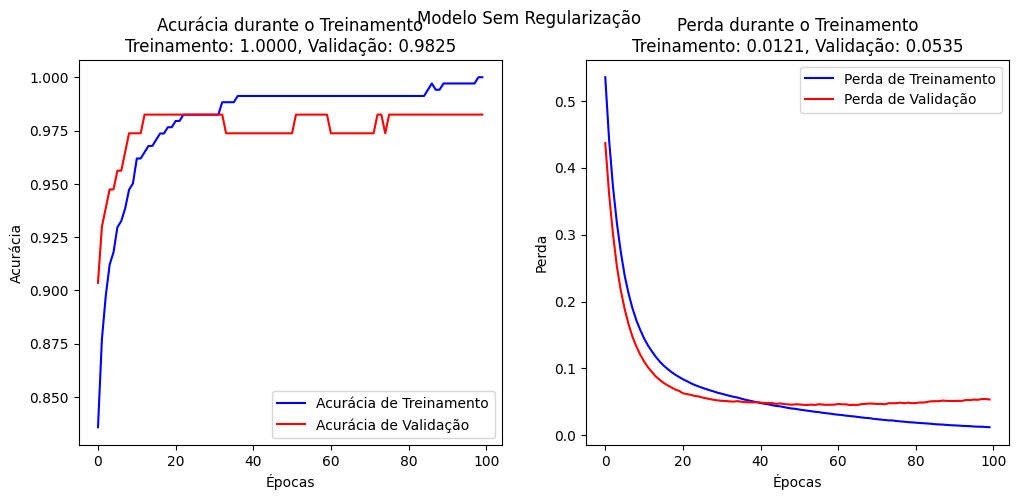

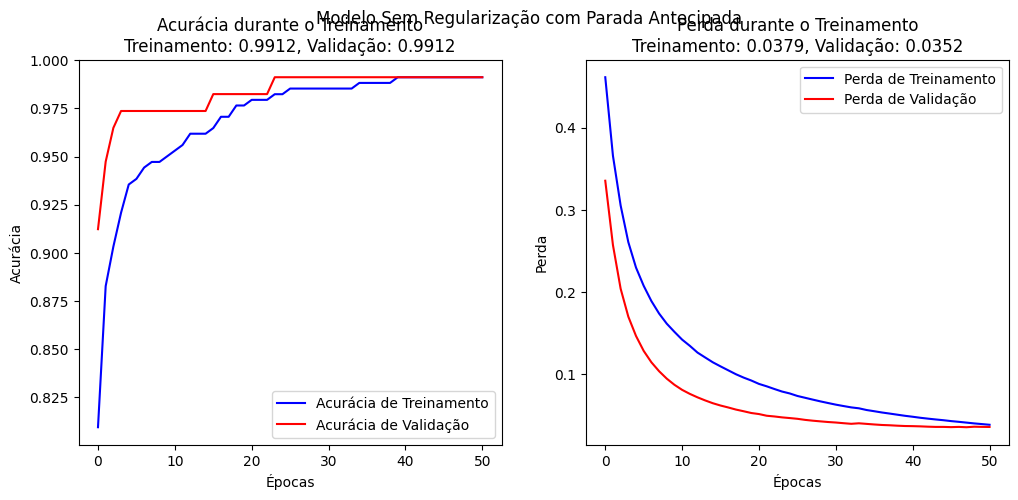

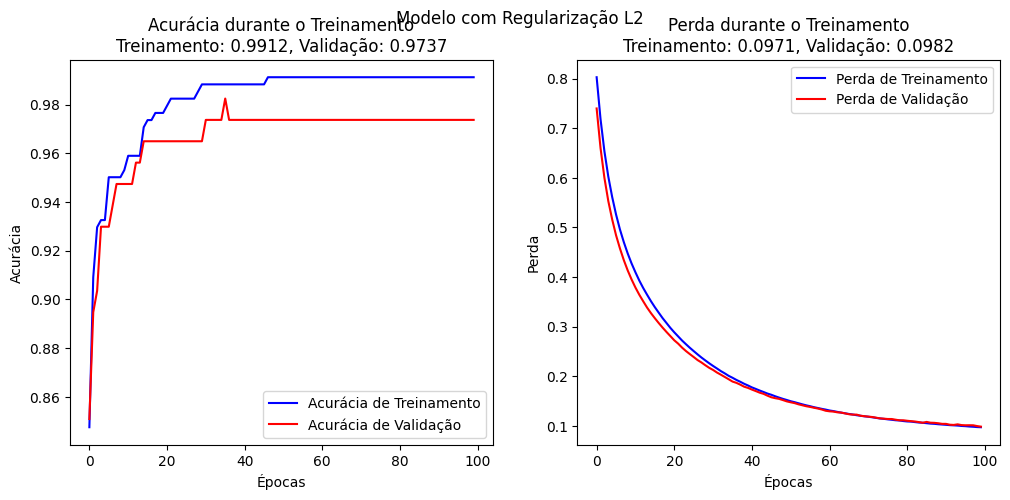

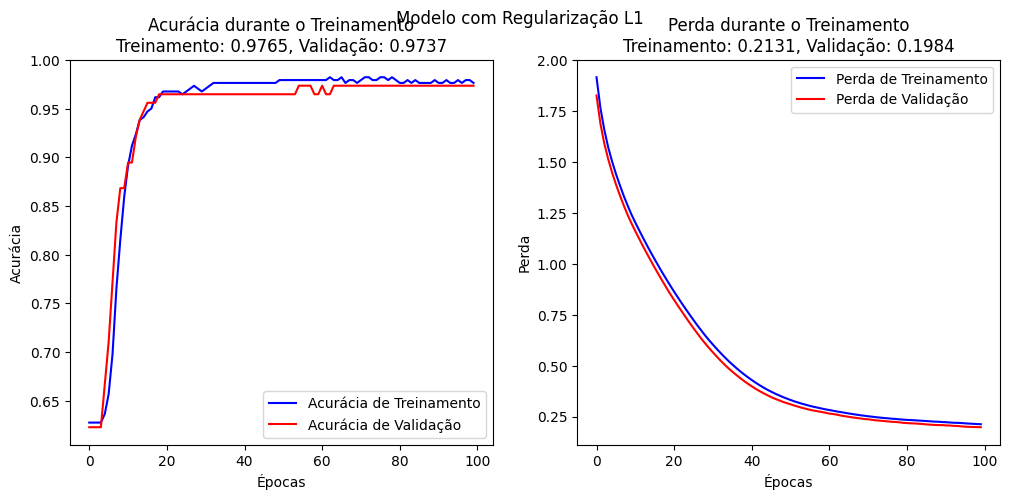

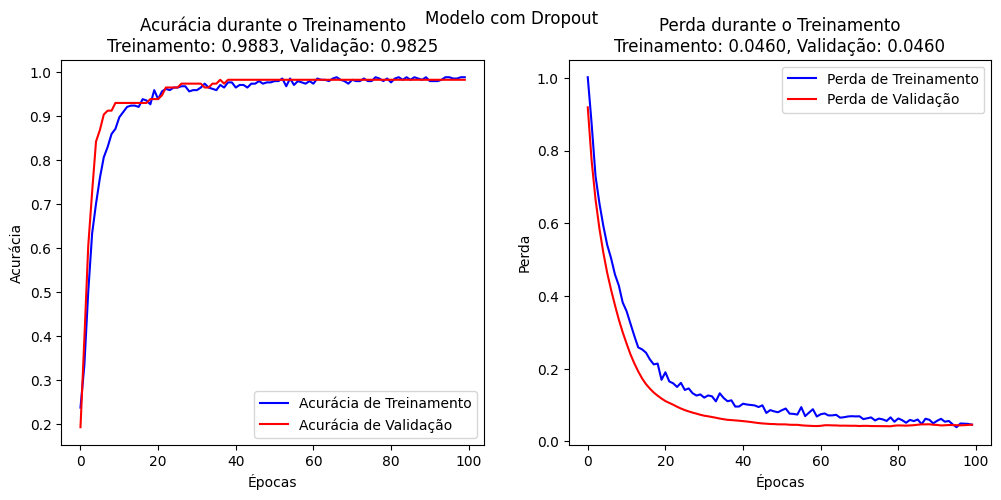

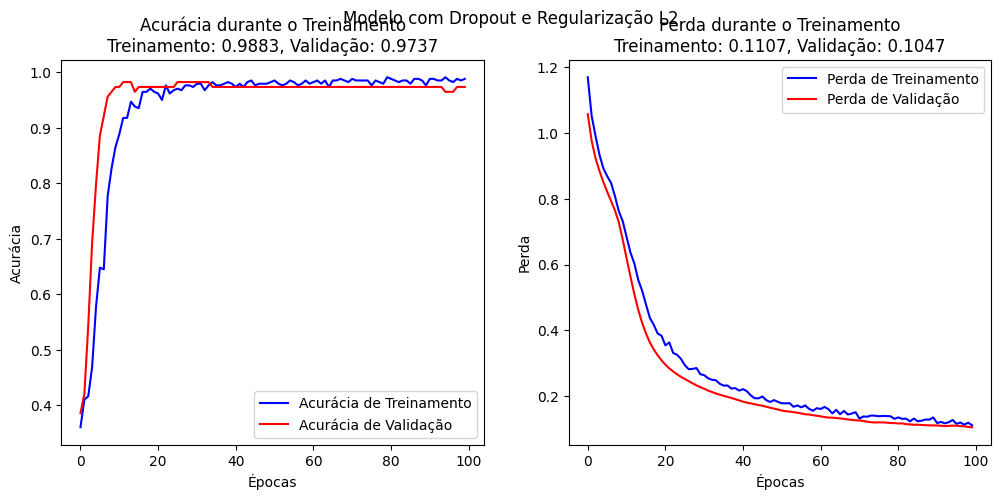

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2
import matplotlib.pyplot as plt

# Carregar a base de dados do arquivo CSV
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
column_names = ['ID', 'Diagnosis'] + [f'Feature_{i}' for i in range(1, 31)]
data = pd.read_csv(url, header=None, names=column_names)

# Separar as características e o alvo
X = data.drop(['ID', 'Diagnosis'], axis=1)
y = data['Diagnosis']

# Converter a coluna 'Diagnosis' para binário: M (maligno) = 1, B (benigno) = 0
y = y.map({'M': 1, 'B': 0})

# Dividir o conjunto de dados em treinamento (80%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

"""## 2. Função para definir os callbacks"""

def create_callbacks(filepath='/tmp/ckpt/checkpoint.model.keras'):
    # Callback para salvar o modelo com melhor acurácia no conjunto de validação
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=filepath,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    # Callback para parada antecipada
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    return [model_checkpoint_callback, early_stopping_callback]

"""## 3. Definir o Modelo Sem Regularização"""

# Definir o modelo sem regularização
def create_model_no_regularization():
    model = Sequential([
        Dense(16, input_shape=(X_train.shape[1],), activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

"""## 4. Definir o modelo sem regularização com parada antecipada"""

# Definir o modelo sem regularização com parada antecipada
def create_model_no_reg_early_stop():
    model = create_model_no_regularization()
    callbacks = create_callbacks()
    return model, callbacks

"""## 5. Definir o Modelo com Regularização L2"""

# Definir o modelo com regularização L2
def create_model_l2():
    model = Sequential([
        Dense(16, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l2(0.01)),
        Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

"""## 6. Definir o modelo com regularização L1"""

# Definir o modelo com regularização L1
def create_model_l1():
    model = Sequential([
        Dense(16, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l1(0.01)),
        Dense(8, activation='relu', kernel_regularizer=l1(0.01)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

"""## 7. Definir o modelo com Dropout"""

# Definir o modelo com Dropout de 30% na segunda camada
def create_model_dropout():
    model = Sequential([
        Dense(16, input_shape=(X_train.shape[1],), activation='relu'),
        Dropout(0.3),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

"""## 8. Definir o modelo com Dropout e Regularização L2"""

# Definir o modelo com Dropout e Regularização L2
def create_model_dropout_l2():
    model = Sequential([
        Dense(16, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

"""## 9. Treinar e avaliar os modelos"""

# Função para treinar e avaliar o modelo
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs, callbacks=None):
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    # Avaliar o desempenho no conjunto de teste
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Loss no teste: {test_loss:.4f}, Acurácia no teste: {test_accuracy:.4f}")

    return history, test_accuracy

# Dicionário para armazenar as acurácias dos modelos
model_accuracies = {}

# Treinar e avaliar os modelos
model_no_reg = create_model_no_regularization()
history_no_reg, acc_no_reg = train_and_evaluate_model(model_no_reg, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100)
model_accuracies['Modelo Sem Regularização'] = acc_no_reg

model_no_reg_early_stop, callbacks_no_reg_early_stop = create_model_no_reg_early_stop()
history_no_reg_early_stop, acc_no_reg_early_stop = train_and_evaluate_model(model_no_reg_early_stop, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100, callbacks=callbacks_no_reg_early_stop)
model_accuracies['Modelo Sem Regularização com Parada Antecipada'] = acc_no_reg_early_stop

model_l2 = create_model_l2()
history_l2, acc_l2 = train_and_evaluate_model(model_l2, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100)
model_accuracies['Modelo com Regularização L2'] = acc_l2

model_l1 = create_model_l1()
history_l1, acc_l1 = train_and_evaluate_model(model_l1, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100)
model_accuracies['Modelo com Regularização L1'] = acc_l1

model_dropout = create_model_dropout()
history_dropout, acc_dropout = train_and_evaluate_model(model_dropout, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100)
model_accuracies['Modelo com Dropout'] = acc_dropout

model_dropout_l2 = create_model_dropout_l2()
history_dropout_l2, acc_dropout_l2 = train_and_evaluate_model(model_dropout_l2, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100)
model_accuracies['Modelo com Dropout e Regularização L2'] = acc_dropout_l2

"""## Escolha do melhor modelo"""

# Encontrar o nome do modelo com a melhor acurácia no teste
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model_name]

print(f"O melhor modelo é: {best_model_name} com acurácia no teste de {best_accuracy:.4f}")

# Carregar o melhor modelo salvo durante o treinamento (se aplicável)
best_model = keras.models.load_model('/tmp/ckpt/checkpoint.model.keras')

# Avaliar o desempenho do melhor modelo no conjunto de teste
best_test_loss, best_test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Melhor Loss no teste: {best_test_loss:.4f}, Melhor Acurácia no teste: {best_test_accuracy:.4f}")

def plot_history(history, title="Model Performance"):
    # Obter os valores finais de acurácia e perda
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'b', label='Acurácia de Treinamento')
    plt.plot(history.history['val_accuracy'], 'r', label='Acurácia de Validação')
    plt.title(f'Acurácia durante o Treinamento\nTreinamento: {final_train_accuracy:.4f}, Validação: {final_val_accuracy:.4f}')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'b', label='Perda de Treinamento')
    plt.plot(history.history['val_loss'], 'r', label='Perda de Validação')
    plt.title(f'Perda durante o Treinamento\nTreinamento: {final_train_loss:.4f}, Validação: {final_val_loss:.4f}')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.suptitle(title)
    plt.show()

# Plotar os históricos de treinamento para cada modelo
plot_history(history_no_reg, "Modelo Sem Regularização")
plot_history(history_no_reg_early_stop, "Modelo Sem Regularização com Parada Antecipada")
plot_history(history_l2, "Modelo com Regularização L2")
plot_history(history_l1, "Modelo com Regularização L1")
plot_history(history_dropout, "Modelo com Dropout")
plot_history(history_dropout_l2, "Modelo com Dropout e Regularização L2")